# Linear Regression, kNN Regression, and Inference

[Resource](https://harvard-iacs.github.io/2018-CS109A/lectures/lecture-4/)

# Part 1: Load Basic Python Modules

In [19]:
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [20]:
df_adv = pd.read_csv("../data/Advertising.csv")

Now get a subset of the data:

In [21]:
data_x = df_adv.TV[5:13]
data_y = df_adv.sales[5:13]

In [22]:
data_x

5       8.7
6      57.5
7     120.2
8       8.6
9     199.8
10     66.1
11    214.7
12     23.8
Name: TV, dtype: float64

# Part 3: Sort the Data

We need to sort the data in order to apply the KNN algorithm.

In [23]:
idx = np.argsort(data_x).values # Get indices ordered from lowest to highest values
idx

array([3, 0, 7, 1, 5, 2, 4, 6])

Remember that the above output are the indices from `data_x`, not the indices from `df_adv`.

In [24]:
# Get the actual data in the order from above
data_x = data_x.iloc[idx]
data_y = data_y.iloc[idx]

In [25]:
data_x

8       8.6
5       8.7
12     23.8
6      57.5
10     66.1
7     120.2
9     199.8
11    214.7
Name: TV, dtype: float64

In [26]:
data_y

8      4.8
5      7.2
12     9.2
6     11.8
10     8.6
7     13.2
9     10.6
11    17.4
Name: sales, dtype: float64

Now here's a function that finds the index of the nearest neighbor and returns the value of the nearest neighbor. Note that this is just for k=1 and the distance function is simply the absolute value.

In [27]:
def find_nearest(array, value):
    idx = (np.abs(array-value)).idxmin()
    return idx, array[idx]

Note that we've used the `idxmin` method in our function. This is because `array` is a pandas dataframe and `idxmin()` is designed to work with pandas dataframes. If we are working with a numpy array then the appropriate method would be `argmin()`.

In [28]:
# Create some artificial x-values
x = np.linspace(np.min(data_x), np.max(data_x))

# Initialize the y-values to zero
y = np.zeros((len(x)))

Apply the KNN algorithm. Try to predict the y-value at a given x-value.

Note: You may have tried to use the `range` method in your code before. Enumerate is far better in this case. Look up `range` vs. `enumerate` and you will see why.

In [29]:
for i, xi in enumerate(x):
    y[i] = data_y[find_nearest(data_x, xi)[0]]

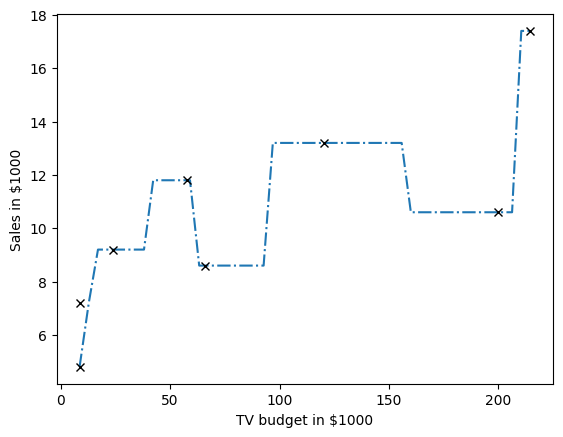

In [30]:
# Plot the solution
plt.plot(x, y, "-.")

# Plot the original data using black x's
plt.plot(df_adv.TV[5:13], df_adv.sales[5:13], "kx")
plt.title('')
plt.xlabel("TV budget in $1000")
plt.ylabel("Sales in $1000");

Now let's move onto the actual example.

# Prediction using kNN and Linear Regression

For this section, our goal is to get you familiarized with k-Nearest Neighbors and Linear. These methods find powerful applications in all walks of life and are centered around prediction.

Specifically, we will:

1. Review Basic Python Data Structures
2. Import Data and Manipulates Rows and Columns
3. Load in the Bikeshare dataset which is split into a training and testing dataset
3. Do some basic exploratory analysis of the dataset and go through a scatterplot
5. Write out the algorithm for kNN WITH AND WITHOUT using the sklearn package
6. Learn to use the sklearn package for Linear Regression.
7. What is and how to extract information about Confidence Intervals.

In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Regression imports
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS
import statsmodels.api as sm

# Metrics, performance evaluation, and helpful functions
from sklearn import metrics, datasets
from collections import Counter
from sklearn.model_selection import train_test_split

# Aesthetic settings
from IPython.display import display
pd.set_option('display.max_rows', 999)
pd.set_option('display.width', 500)
pd.set_option('display.notebook_repr_html', True)

# Working with Dataframes

## Importing data

This data describes the population per state from 1900 to 2010.

In [32]:
data_path = "../data/states.csv"
states = pd.read_csv(data_path, index_col=0)
states.head()

,1790,1800,1810,1820,1830,1840,1850,1860,1870,1880,...,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010
Alabama,0,1250,9046,127901,309527,590756,771623,964201,996992,1262505,...,2348174,2646248,2832961,3061743,3266740,3444165,3893888,4040587,4447100,4779736
Alaska,0,0,0,0,0,0,0,0,0,0,...,55036,59278,72524,128643,226167,300382,401851,550043,626932,710231
Arizona,0,0,0,0,0,0,0,0,9658,40440,...,334162,435573,499261,749587,1302161,1770900,2718215,3665228,5130632,6392017
Arkansas,0,0,1062,14273,30388,97574,209897,435450,484471,802525,...,1752204,1854482,1949387,1909511,1786272,1923295,2286435,2350725,2673400,2915918
California,0,0,0,0,0,0,92597,379994,560247,864694,...,3426861,5677251,6907387,10586223,15717204,19953134,23667902,29760021,33871648,37253956
